# Automatic Instance Segmentation with Segment Anything (SAM)

Here is an example for evaluating the automatic segmentation capability of SAM on immunoflourescence microscopic images, abbreviated as `Covid IF` (Pape et al. - Microscopy-based assay for semi-quantitative detection of SARS-CoV-2 specific antibodies in human sera - https://doi.org/10.1002/bies.202000257).

We compare two settings:
1. Automatic Mask Generation (AMG): The "Segment Anything" feature where a grid of positive point prompts are sampled over the entire image to perform instance segmentation.
2. Automatic Instance Segmentation (AIS): The feature in `µsam` (Segment Anything for Microscopy) where we introduce an additional decoder to perform automatic instance segmentation.

## Let's check, where are you now?

**NOTE**: The scripts have been tested on our recommended open-source cloud servers, [Kaggle Notebooks](https://www.kaggle.com/code/).

In [1]:
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    using_kaggle = True
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

else:
    if current_spot.startswith("/content"):
        using_colab = True
        print("Google Colab says hi!")
        print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
        root_dir = "/content"

        # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
        # !pip install -q condacolab
        # import condacolab
        # condacolab.install()
    
    else:
        msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
        msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
        print(msg)
        root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


## Installation

Let's install all the relevant dependencies required for inference.

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git
tmp_dir = os.path.join(root_dir, "micro-sam")
!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py
!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47929eba.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3e39a7aa.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/4ea078d6.json" was modified by another program
Preparing 

## Importing the libraries

In [7]:
import os
from glob import glob

import h5py
import matplotlib.pyplot as plt

from torch_em.data.datasets.covid_if import _download_covid_if

from micro_sam import util
from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    AutomaticMaskGenerator,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

## Let's download the dataset

In [8]:
data_dir = os.path.join(root_dir, "data", "covid_if")
_download_covid_if(path=data_dir, download=True)
print(f"Your data is stored at: {data_dir}")

Download https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1 to /kaggle/working/data/covid_if/covid-if.zip: 100%|██████████| 491M/491M [05:46<00:00, 1.48MB/s] 


Download successful and checksums agree.
Your data is stored at: /kaggle/working/data/covid_if


## Let's visualize how our samples look

In [9]:
# Convenience function to plot images side-by-side
def plot_samples(image, gt, segmentation=None):
    n_images = 2 if segmentation is None else 3
    fig, ax = plt.subplots(1, n_images, figsize=(10, 10))
    
    ax[0].imshow(_enhance_image(image), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Image")
    
    ax[1].imshow(gt)
    ax[1].axis("off")
    ax[1].set_title("Ground Truth")
    
    if n_images == 3:
        ax[2].imshow(segmentation)
        ax[2].axis("off")
        ax[2].set_title("Prediction")

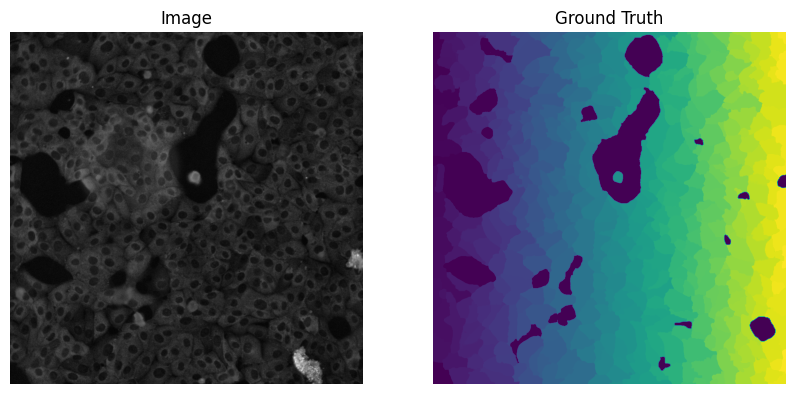

In [11]:
sample_paths = sorted(glob(os.path.join(data_dir, "*")))

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]

    plot_samples(image=raw, gt=labels)

    break  # comment this out in case you want to visualize all images

### Next, let's load the convenience functions for automatic segmentation methods

In [27]:
!ls /root/.cache/micro_sam/models/

vit_b  vit_b_lm  vit_b_lm_decoder


In [49]:
def run_automatic_instance_segmentation(image, model_type="vit_b_lm"):
    """Automatic Instance Segmentation.
    NOTE: It is supported only for µsam models.
    """
    predictor, decoder = get_predictor_and_decoder(model_type=model_type, checkpoint_path=None)
    image_embeddings = util.precompute_image_embeddings(predictor=predictor, input_=image, ndim=2)

    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    ais.initialize(image, image_embeddings=image_embeddings)

    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction


def run_automatic_mask_generation(image, model_type="vit_b"):
    """Automatic Mask Generation.
    NOTE: It is supported for both Segment Anything models and µsam models.
    """
    predictor = util.get_sam_model(model_type=model_type)
    image_embeddings = util.precompute_image_embeddings(predictor=predictor, input_=image, ndim=2)
    
    amg = AutomaticMaskGenerator(predictor)
    amg.initialize(image, image_embeddings=image_embeddings)
    
    prediction = amg.generate(pred_iou_thresh=0.6, stability_score_thresh=0.6)
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

### Let's run the default Segment Anything models

We test the smallest default SAM model on the microscopy data, ViT Base (abbreviated as `vit_b`).

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


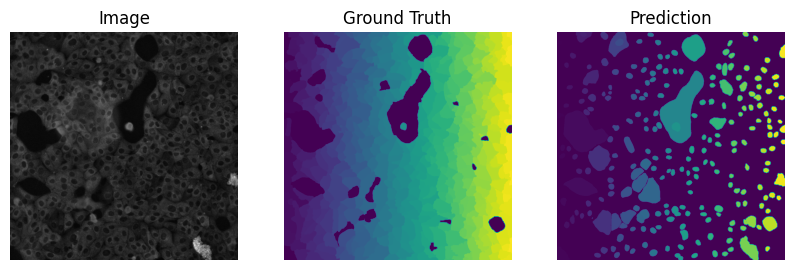

In [23]:
model_choice = "vit_b"

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]
    
    prediction = run_automatic_mask_generation(raw, model_type=model_choice)
    plot_samples(image=raw, gt=labels, segmentation=prediction)
    
    break  # comment this out in case you want to visualize all images

As we see above, Segment Anything does not generalize well for segmenting cells in the above image.

To address this problem, we introduce "Segment Anything for Microscopy". Let's try how AMG works for the finetuned light microscopy generalist model.

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


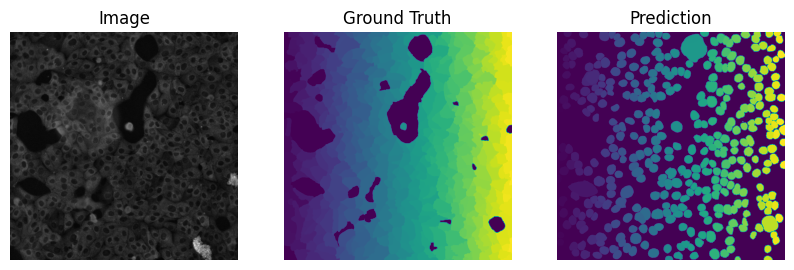

In [51]:
# For consistency, we choose the same configuration of model finetuned on the light microscopy domain.
model_choice = "vit_b_lm"

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]
    
    prediction = run_automatic_mask_generation(raw, model_type=model_choice)
    plot_samples(image=raw, gt=labels, segmentation=prediction)
    
    break  # comment this out in case you want to visualize all images

The segmentation quality is a bit better, but does it achieve our desired results?

To address this problem, `µsam` introduces an additional decoder to improve the segmentation quality by learning the objects with a better heuristic.

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


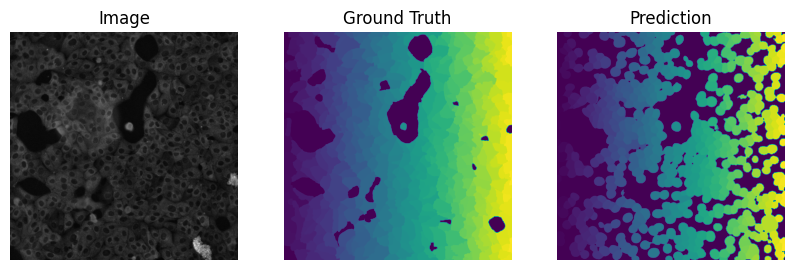

In [37]:
# For consistency, we choose the same configuration of model finetuned on the light microscopy domain.
model_choice = "vit_b_lm"

for sample_path in sample_paths:
    with h5py.File(sample_path, "r") as f:
        raw = f["raw/serum_IgG/s0"][:]
        labels = f["labels/cells/s0"][:]
    
    prediction = run_automatic_instance_segmentation(raw, model_type=model_choice)
    plot_samples(image=raw, gt=labels, segmentation=prediction)
    
    break  # comment this out in case you want to visualize all images

## What next?

Question: Are you happy with the segmentations?

1. If your answer is "YES", looks like you are good to go with your segmentations. Feel free to test it on your custom data.
2. If you think there are missed out objects / incorrect segmentations, and there's room for improvement:
    1. We recommend you to use our napari-based [annotation tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools) to improve your segmentations.
    2. If you want to improve the automatic segmentation quality, we recommend you to finetune the default SAM models OR the `µsam` models, based on your initial assessment of the segmentation quality of both models.
3. If you think the models perform poorly, we recommend you to finetune the default SAM models on your custom dataset. There are two situations here:
    1. In case you do not have any ground-truth labels, we recommend generating the desired labels using our [annotator tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)
    2. In case you do have ground-truth labels, we suggest going ahead with finetuning already (you can choose to use the [python scripts](TODO) or the [tool](TODO) for this.)
    
[Here](TODO) is the link on how to get quickly started with finetuning on your custom dataset.

*This notebook was last ran on Apr 24, 2024*